In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-classification/2", input_shape=IMAGE_SHAPE+(3,))
])

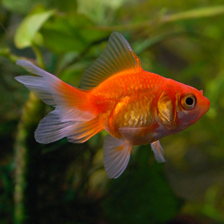

In [3]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [4]:
def preprocess_image(image):
    image = tf.image.resize(image, IMAGE_SHAPE) / 255.0
    image = tf.expand_dims(image, 0)
    return image

In [5]:
gold_fish=preprocess_image(gold_fish)

In [6]:
gold_fish.shape

TensorShape([1, 224, 224, 3])

In [7]:
result = classifier.predict(gold_fish)

1/1 [==============================] - 1s 737ms/step


In [8]:
result.shape

(1, 1001)

In [9]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [10]:
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

'/root/.keras/datasets/ImageNetLabels.txt'

In [11]:
image_labels = []
with open("/root/.keras/datasets/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
image_labels[predicted_label_index]

'goldfish'

In [13]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [14]:
data_dir='./datasets/flower_photos'

In [15]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [16]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/2675221506_5286c0595f.jpg'),
 PosixPath('datasets/flower_photos/roses/7525783408_0999483bf4_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5537794501_a0767743fd_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3655527028_0fab2b547d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15190665092_5c1c37a066_m.jpg')]

In [17]:
import PIL

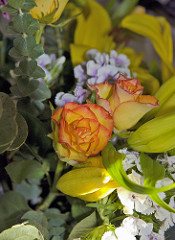

In [18]:
PIL.Image.open(str(roses[1]))

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [20]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [21]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/2675221506_5286c0595f.jpg'),
 PosixPath('datasets/flower_photos/roses/7525783408_0999483bf4_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5537794501_a0767743fd_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3655527028_0fab2b547d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15190665092_5c1c37a066_m.jpg')]

In [22]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/2675221506_5286c0595f.jpg'

In [23]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [24]:
img.shape

(375, 500, 3)

In [25]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [26]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [27]:
X = np.array(X)
y = np.array(y)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [29]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [30]:
X[2].shape

(224, 224, 3)

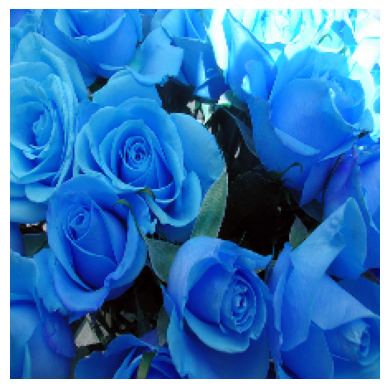

In [31]:
plt.axis('off')
plt.imshow(X[0])

In [32]:
predicted = classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 539ms/step


array([795, 795, 816])

In [33]:
image_labels[795],image_labels[816]

('shower curtain', 'spider web')

### Now take pre-trained model and retrain it using flowers images

In [34]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [35]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 416613 (1.59 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)